<h3>Importing Functions

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
from kneed import KneeLocator
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans
from scipy import fft
from scipy.stats import gmean
from sklearn.naive_bayes import MultinomialNB
import tqdm
from sklearn.model_selection import train_test_split,GridSearchCV, train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report
from seaborn import pairplot
import numpy.linalg as LA
import scipy.stats as sp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


<h3>Coding Function

In [141]:
def condense_csv(csv_index,dictionary=False,bearing=4):
    '''
    Function to retrieve explanatory variables from signal data.
    
    args:
    csv_index = integer value representing which csv we have to read from
    ...
    dictionary = False by default, but if the user inputs a dictionary, 
    it will append the retrieved values to the in place dictionary given that it has the appropiate keys:
    mean, std, rms, sf, peak_count, conf_interval_outliers, iqr_outliers
    ...
    bearing = 4 or 1, it signifies which bearing we want to get the variables from 

    returns:

    means, stds, rms, spectral_flatness, peakcount, Norm_Conf,Norm_IQR 

    '''
    #Load and fix data
    data = pd.read_csv(str(csv_index)+'.csv')
    data[['b1x', 'b1y', 'b4x', 'b4y']] = data['b1x;b1y;b4x;b4y'].str.split(';', expand=True)
    data = data.drop(columns=['b1x;b1y;b4x;b4y'])
    data[['b1x', 'b1y', 'b4x', 'b4y']] = data[['b1x', 'b1y', 'b4x', 'b4y']].apply(pd.to_numeric)

    axis_list=['b'+str(bearing)+'x','b'+str(bearing)+'y']
    bearing_data= data[axis_list].to_numpy()
    #retrieve mean, std and rms
    means=bearing_data.mean()
    stds=bearing_data.std(ddof=1)
    rms=((bearing_data**2).mean()**0.5)
    #apply FFT on both axis, then normalize and retrieve IQR and Confidence Interval outliers
    fft_x=abs(fft.fft(data[axis_list[0]].to_numpy()))
    fft_y=abs(fft.fft(data[axis_list[1]].to_numpy()))
    fft_acce=np.array([fft_y,fft_x])[:,1:]
    fft_acce_norm=LA.norm(fft_acce,axis=0)
    fitted_shape, loc, fitted_scale = sp.gamma.fit(fft_acce_norm)

    upper_bound = sp.gamma.ppf(1- 1e-10, fitted_shape, loc=loc, scale=fitted_scale)

    power_spectrum=np.square(fft_acce_norm)
    spectral_flatness=(gmean(power_spectrum)/power_spectrum.mean())

    Q1 = np.percentile(fft_acce_norm,25,axis=0)
    Q3 = np.percentile(fft_acce_norm,75,axis=0)

    IQR = Q3 - Q1

    norm_conf=(fft_acce_norm > upper_bound).sum()

    upper_bound = Q3 + 1.5 * IQR
    norm_iqr=(fft_acce_norm>upper_bound).sum() 
    #IQR for retrieving peak count
    Q1 = np.percentile(bearing_data,25,axis=0)
    Q3 = np.percentile(bearing_data,75,axis=0)

    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q3 - 1.5 * IQR

    peakcount=((bearing_data[:,0]>upper_bound[0]) & (bearing_data[:,1]>upper_bound[1])).sum()
    peakcount+=((bearing_data[:,0]<lower_bound[0]) & (bearing_data[:,1]<lower_bound[1])).sum()
    #extend dictionary with retrieved data
    if type(dictionary) == dict:
        dictionary['mean'].append(means)
        dictionary['std'].append(stds)
        dictionary['rms'].append(rms)
        dictionary['sf'].append(spectral_flatness)
        dictionary['peak_count'].append(peakcount)
        dictionary['conf_interval_outliers'].append(norm_conf)
        dictionary['iqr_outliers'].append(norm_iqr)
    return means, stds, rms, spectral_flatness, peakcount, norm_conf,norm_iqr

<h3> Reading csv files and condensing them

Text(0.5, 1.0, 'Change in X-Axis Acceleration through out 1 Second')

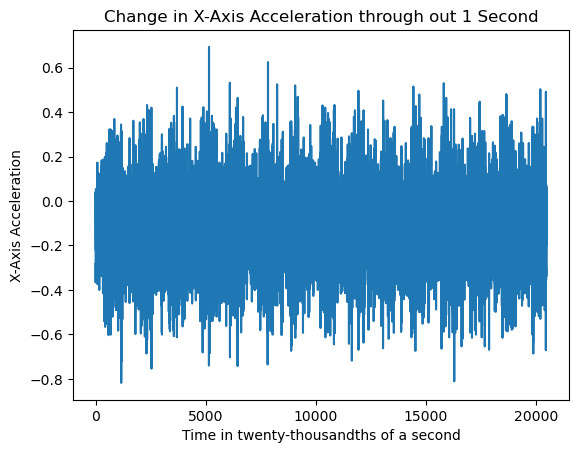

In [199]:
data = pd.read_csv(str(1700)+'.csv')
data[['b1x', 'b1y', 'b4x', 'b4y']] = data['b1x;b1y;b4x;b4y'].str.split(';', expand=True)
data = data.drop(columns=['b1x;b1y;b4x;b4y'])
data[['b1x', 'b1y', 'b4x', 'b4y']] = data[['b1x', 'b1y', 'b4x', 'b4y']].apply(pd.to_numeric)
plt.plot(data['b4x'])
plt.xlabel('Time in twenty-thousandths of a second')
plt.ylabel('X-Axis Acceleration')
plt.title('Change in X-Axis Acceleration through out 1 Second')


In [78]:
y=list(pd.read_csv('00bearing_conditions.csv').iloc[:,0])
data_bearing_4={'mean':[],'std':[],
                'rms':[],'sf':[],
                'peak_count':[],'conf_interval_outliers':[],
                'iqr_outliers':[],'bearing_condition' : y}

for i in tqdm.tqdm(range(1724)):
    condense_csv(i,data_bearing_4)
df_bearing_4=pd.DataFrame(data_bearing_4)

100%|██████████| 1724/1724 [06:22<00:00,  4.50it/s]


In [83]:
y=list(pd.read_csv('00bearing_conditions.csv').iloc[:,0])
data_bearing_1={'mean':[],'std':[],
                'rms':[],'sf':[],
                'peak_count':[],'conf_interval_outliers':[],
                'iqr_outliers':[]}

for i in tqdm.tqdm(range(1724)):
    condense_csv(i,data_bearing_1,bearing=1)
df_bearing_1=pd.DataFrame(data_bearing_1)


100%|██████████| 1724/1724 [07:13<00:00,  3.97it/s]


In [84]:
df_bearing_1.to_csv('bearing_1_prediction_data.csv')
df_bearing_4.to_csv('bearing_4_prediction_data.csv')

To summarise, we added Peak Count and IQR outliers and Confidence Interval Outliers to the features and exported condensed files, so that re-condensing isn't necessary as it is quite time intensive

<h1> Exercise 1C Onwards

In [265]:
dat = pd.read_csv('bearing_4_prediction_data.csv', index_col= 0)
dat.head()
cols = list(dat.columns)
cols.remove('conf_interval_outliers')
dat = dat[cols]

In [303]:
X = dat.drop('bearing_condition', axis=1)
y = dat['bearing_condition']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the models
log_reg = LogisticRegression()
rf_clf = RandomForestClassifier(random_state=42)
LDA = LinearDiscriminantAnalysis()
neural_clf = MLPClassifier(hidden_layer_sizes=(500,), max_iter=5000, random_state=42)
SVC_clf = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
# Train the models
log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
LDA.fit(X_train, y_train)
SVC_clf.fit(X_train, y_train)
neural_clf.fit(X_train, y_train)
# Make predictions
y_pred_log_reg = log_reg.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_lda = LDA.predict(X_test)
y_pred_svc = SVC_clf.predict(X_test)
y_pred_nn = neural_clf.predict(X_test) 

In [281]:
param_grid_rf = {
   'n_estimators': [20, 50, 90,150],
   'max_depth': [3, 5, 8,15],
   'min_samples_split': [2, 5, 10 , 15],
   'min_samples_leaf': [1, 4, 8, 15]
}

rf = RandomForestClassifier(random_state=42)

# Use random search to find the best hyperparameters
gridsearchRF = GridSearchCV(rf, param_grid_rf, cv=5)

# Fit the random search object to the data
gridsearchRF.fit(X_train, y_train)
y_pred_gsrf=gridsearchRF.best_estimator_.predict(X_test)

In [298]:
print("Grid-Search Random Forest Classification Report:\n", classification_report(y_test, y_pred_gsrf))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("SVC Classification Report:\n", classification_report(y_test, y_pred_svc))
print("Linear Discriminant Analysis Classification Report:\n", classification_report(y_test, y_pred_lda))
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_nn))

Grid-Search Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.87      0.91      0.89       143
           2       0.81      0.73      0.77        66
           3       0.98      0.95      0.96        58
           4       0.94      0.98      0.96        49

    accuracy                           0.89       345
   macro avg       0.90      0.90      0.90       345
weighted avg       0.89      0.89      0.89       345

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91        29
           1       0.82      0.92      0.87       143
           2       0.75      0.62      0.68        66
           3       0.94      0.83      0.88        58
           4       0.92      0.96      0.94        49

    accuracy                           0.85       345
   macro avg       0.87      0.85    

In [304]:
print("Grid-Search Random Forest Accuracy:", accuracy_score(y_test, y_pred_gsrf))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("SVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Linear Discriminant Analysis Accuracy:", accuracy_score(y_test, y_pred_lda))
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))

Grid-Search Random Forest Accuracy: 0.8927536231884058
Logistic Regression Accuracy: 0.8521739130434782
Random Forest Accuracy: 0.8956521739130435
SVC Accuracy: 0.8840579710144928
Linear Discriminant Analysis Accuracy: 0.8405797101449275
Neural Network Accuracy: 0.8869565217391304


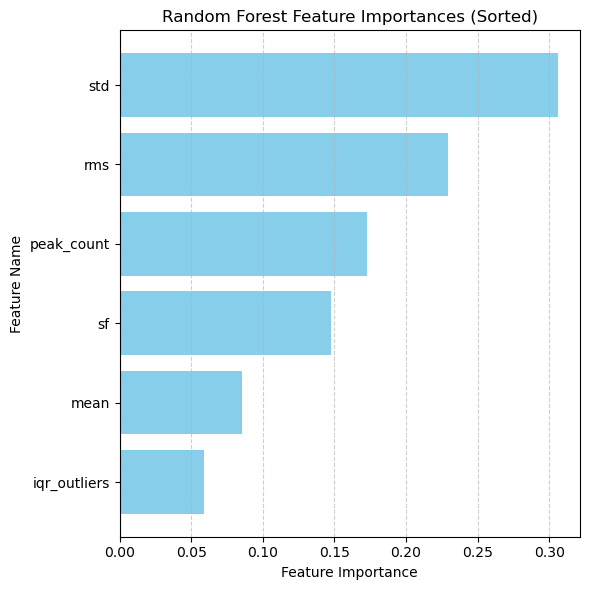

In [286]:
importances = rf_clf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]
importances_sorted = importances[indices]
# Create a sorted bar plot
plt.figure(figsize=(6, 6))  
plt.barh(range(len(feature_names)), importances_sorted, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Random Forest Feature Importances (Sorted)")
plt.yticks(range(len(feature_names)), feature_names, fontsize=10)  
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

e.1) We chose to try a Neural Network, SVC, Naive Bayes, Linear Discriminant Analysis, Logistic Regression and Random Forest. 
1. We chose Naive Bayes and Linear Discriminant analysis to gauge how independent and linear the features are by comparing performance of these models with other ones. 
2. We picked non-linear SVC because it is versatile and set Gamma to auto with choosing a c of 1. We chose 1 to avoid overfitting.
3. We used Logistic regression just because it is easy to implement.
4. We decided on making use of Neural Networks because they are incredibly versatile. We chose 500 hidden layer sizes. We also chose 5000 iterations, because this is approximately what it took to converge.
5. We used Random Forest because it is so versatile and because it ranks features by itself.

e.2) Our best model is the Random Forest model. We looked at the precision and F1 score per degradation stage. Random Forest had precisions above 0.8 for every class, with it predicting the third stage correctly every time. the F1 scores were also really good. Only our SVC model came close, but there is still quite a sizeable gap in performance.

f) 
1. We tried implementing Confidence Interval outliers, performance didn't change. We expected this, since the feature doesn't fit a Gamma distribution correctly for every csv.
2. We tried Grid-Search on it, performance actually got marginally worse. Maybe this is it accounting for overfitting, but we did not expect this.
3. We rewrote the code to not reduce dimensions and get the sf, peak count, std, rms and mean for both x and y acceleration. This did affect the models somewhat, but the performance of the model wasn't much better. We expected the difference would be negligable.

<h1> Exercise 2

Text(0, 0.5, 'Shaft Radius')

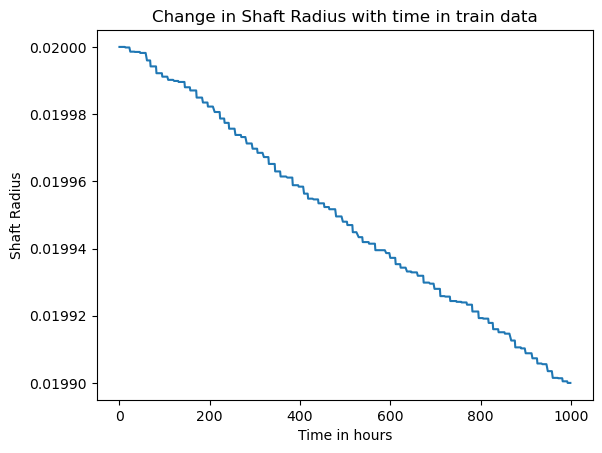

In [122]:
data=pd.read_csv('shaft_radius.csv')
time=data[['measurement_index']]
X_train, X_test, y_train, y_test=train_test_split(time,data['shaft_radius'],random_state=42,train_size=0.8)
X_train, X_test, y_train, y_test=X_train.sort_index(), X_test.sort_index(), y_train.sort_index(), y_test.sort_index()
plt.plot(X_train,y_train)
plt.title('Change in Shaft Radius with time in train data')
plt.xlabel('Time in hours')
plt.ylabel('Shaft Radius')

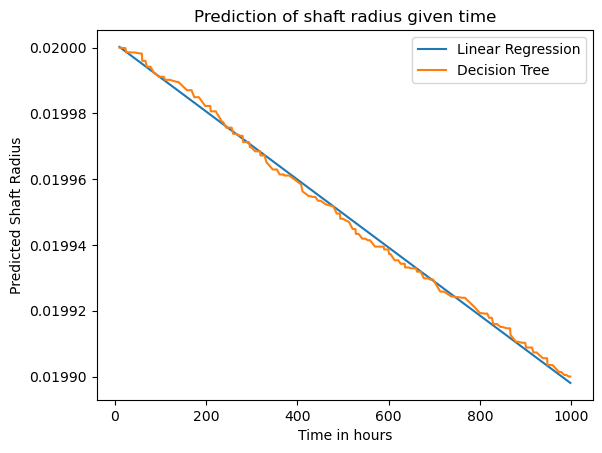

In [123]:
X=sm.add_constant(X_train)
model_decision_tree = DecisionTreeRegressor()
model_decision_tree.fit(X_train, y_train)
y_pred = model_decision_tree .predict(X_test)

linear_model=sm.OLS(y_train,X).fit()
x_test=sm.add_constant(X_test)
pred=linear_model.predict(x_test)

plt.plot(X_test,pred)
plt.plot(X_test,y_pred)
plt.title('Prediction of shaft radius given time')
plt.xlabel('Time in hours')
plt.ylabel('Predicted Shaft Radius')
plt.legend(['Linear Regression','Decision Tree'])

Model and data metrics

                            OLS Regression Results                            
Dep. Variable:           shaft_radius   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.913e+05
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:45:13   Log-Likelihood:                 9558.8
No. Observations:                 800   AIC:                        -1.911e+04
Df Residuals:                     798   BIC:                        -1.910e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0200    1.1e-0

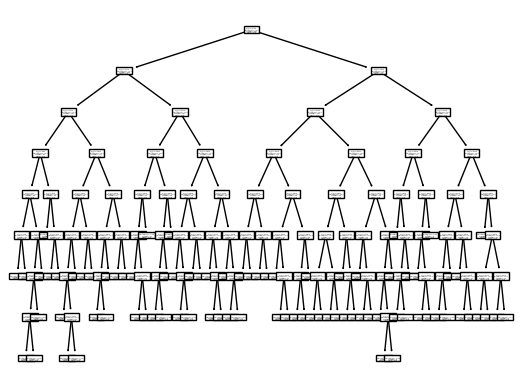

In [135]:
plot_tree(model_decision_tree)

pears_r=pearsonr(y_train,X_train['measurement_index'])[0]
print(linear_model.summary())

In [124]:
print(f' MSE Of Linear Model = {mean_squared_error(y_test,pred)}\n',
      f'Residuals Of Linear Model = {sum(y_test-pred)}\n',
      f'R2 Score Of Linear Model = {r2_score(y_test,pred)}\n\n',
      f'MSE Of Decision Tree = {mean_squared_error(y_test,y_pred)}\n',
      f'Residuals Of Decision Tree = {sum(y_test-y_pred)}\n',
      f'R2 Score Of Decision Tree = {r2_score(y_test,y_pred)}\n\n',
      f"Pearson R coefficient for proving linear correlation of data in general = {pears_r}")

 MSE Of Linear Model = 2.466383137757657e-12
 Residuals Of Linear Model = -2.2140639958530967e-05
 R2 Score Of Linear Model = 0.9971695469602758

 MSE Of Decision Tree = 1.953400203206739e-13
 Residuals Of Decision Tree = -1.647789925290563e-05
 R2 Score Of Decision Tree = 0.9997758252779821

 Pearson R coefficient for proving linear correlation of data in general = -0.9986332649821557


We have chosen the linear model instead of the decision tree. There are main 4 reasons:
1. The increase in R2 Score and MSE performance for a Decision Tree is very minimal. At some point, choosing a more complex model brings diminishing returns and we believe that point has been reached.
2. The simplicity of a Linear Regression model is great. It allows us to describe the decrease in Shaft radius according to the formula $\frac{1}{50} -1.034\cdot 10^{-7}\cdot x$
3. Linear Regression models are better at predicting data outside the training range. In practice, a decision tree always has arbitrary borders, making it less accurate for predicting shaft radius after 1000 hours of machine operation. The Linear Regression model will not have this issue, mitigating any issues this could cause for predicting values past the 1000 hours.
4. Due to the nature of the data, there is some noise that carries over from 1 data point to the next. Knowing if the decision tree boundary was decided based on noise specific to this specific data or actual patterns in shaft radius degradation is incredibly difficult. to summarise this, overfitting is harder to prevent or detect.

We understand that assignment did say there was interest in capturing the way shaft radius degrades more heavily at some periods than others. But we really do believe that the added value of capturing this behaviour is not worth losing the benefits of a Linear model.

d.1) To ensure that the model is good without ovefitting, we look at the following metrics: residuals, MSE and R2 score of the predicted values of the test set. Since our regression model is linear, these metrics are quite reasonable. residuals and pearson r confirm that the model and data are linear. MSE and R2 are for checking the performance of the model. 

1. We have good evidence that the model isn't overfitting and is also performing well. 

2. Variance wise however, we don't know how the model would perform with unseen data. This is because all values in train data are extremely representative of the test data. So values after 1000 hours cannot be confidently predicted and if this datasets variation isn't representative of all shaft radii, there will be a lot more incorrect predictions.


d.2) Yes, this model is reliable. The MSE and R2 Score are very good and doesn't seem to overfit making it quite generic. We would be more wary of using it for values past 1000 hours as we do not know if it will still behave linearly. we look at the pearson r coefficient before fitting and it is incredibly linear, so it should just fit really well in general. What supports our conclusion is that linear models have way less risk of overfitting when compared to polynomial models for example.

d.3) Our ideas are:
1. to perform cross validation on the data
2. grab more data sets on shaft degradation and include them in the model. Since right now the model is based of off a single shaft's data and our assumption is that this single shaft doesn't represents all other shafts.
3. Research about how shaft degradation occurs and if it remains linear or if after a lot of the shaft is degraded, then it degrades differently. 


<h1> Exercise 3

In [139]:
data_ex3= pd.read_csv('bearing_1_prediction_data.csv')
cols=list(data_ex3.columns)
cols[0] = 'time'
data_ex3.columns=cols

<Figure size 640x480 with 0 Axes>

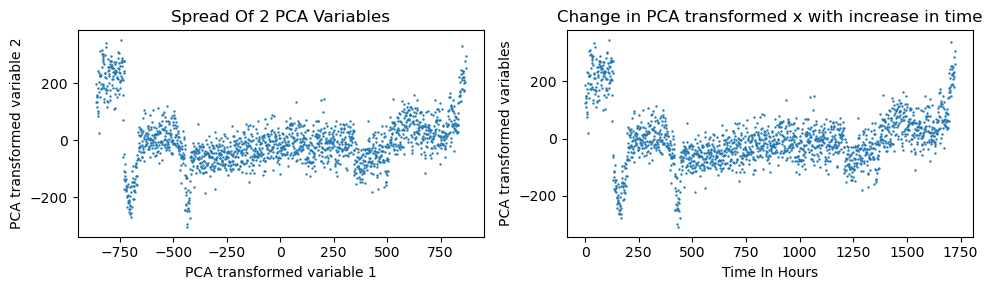

c:\Users\danin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


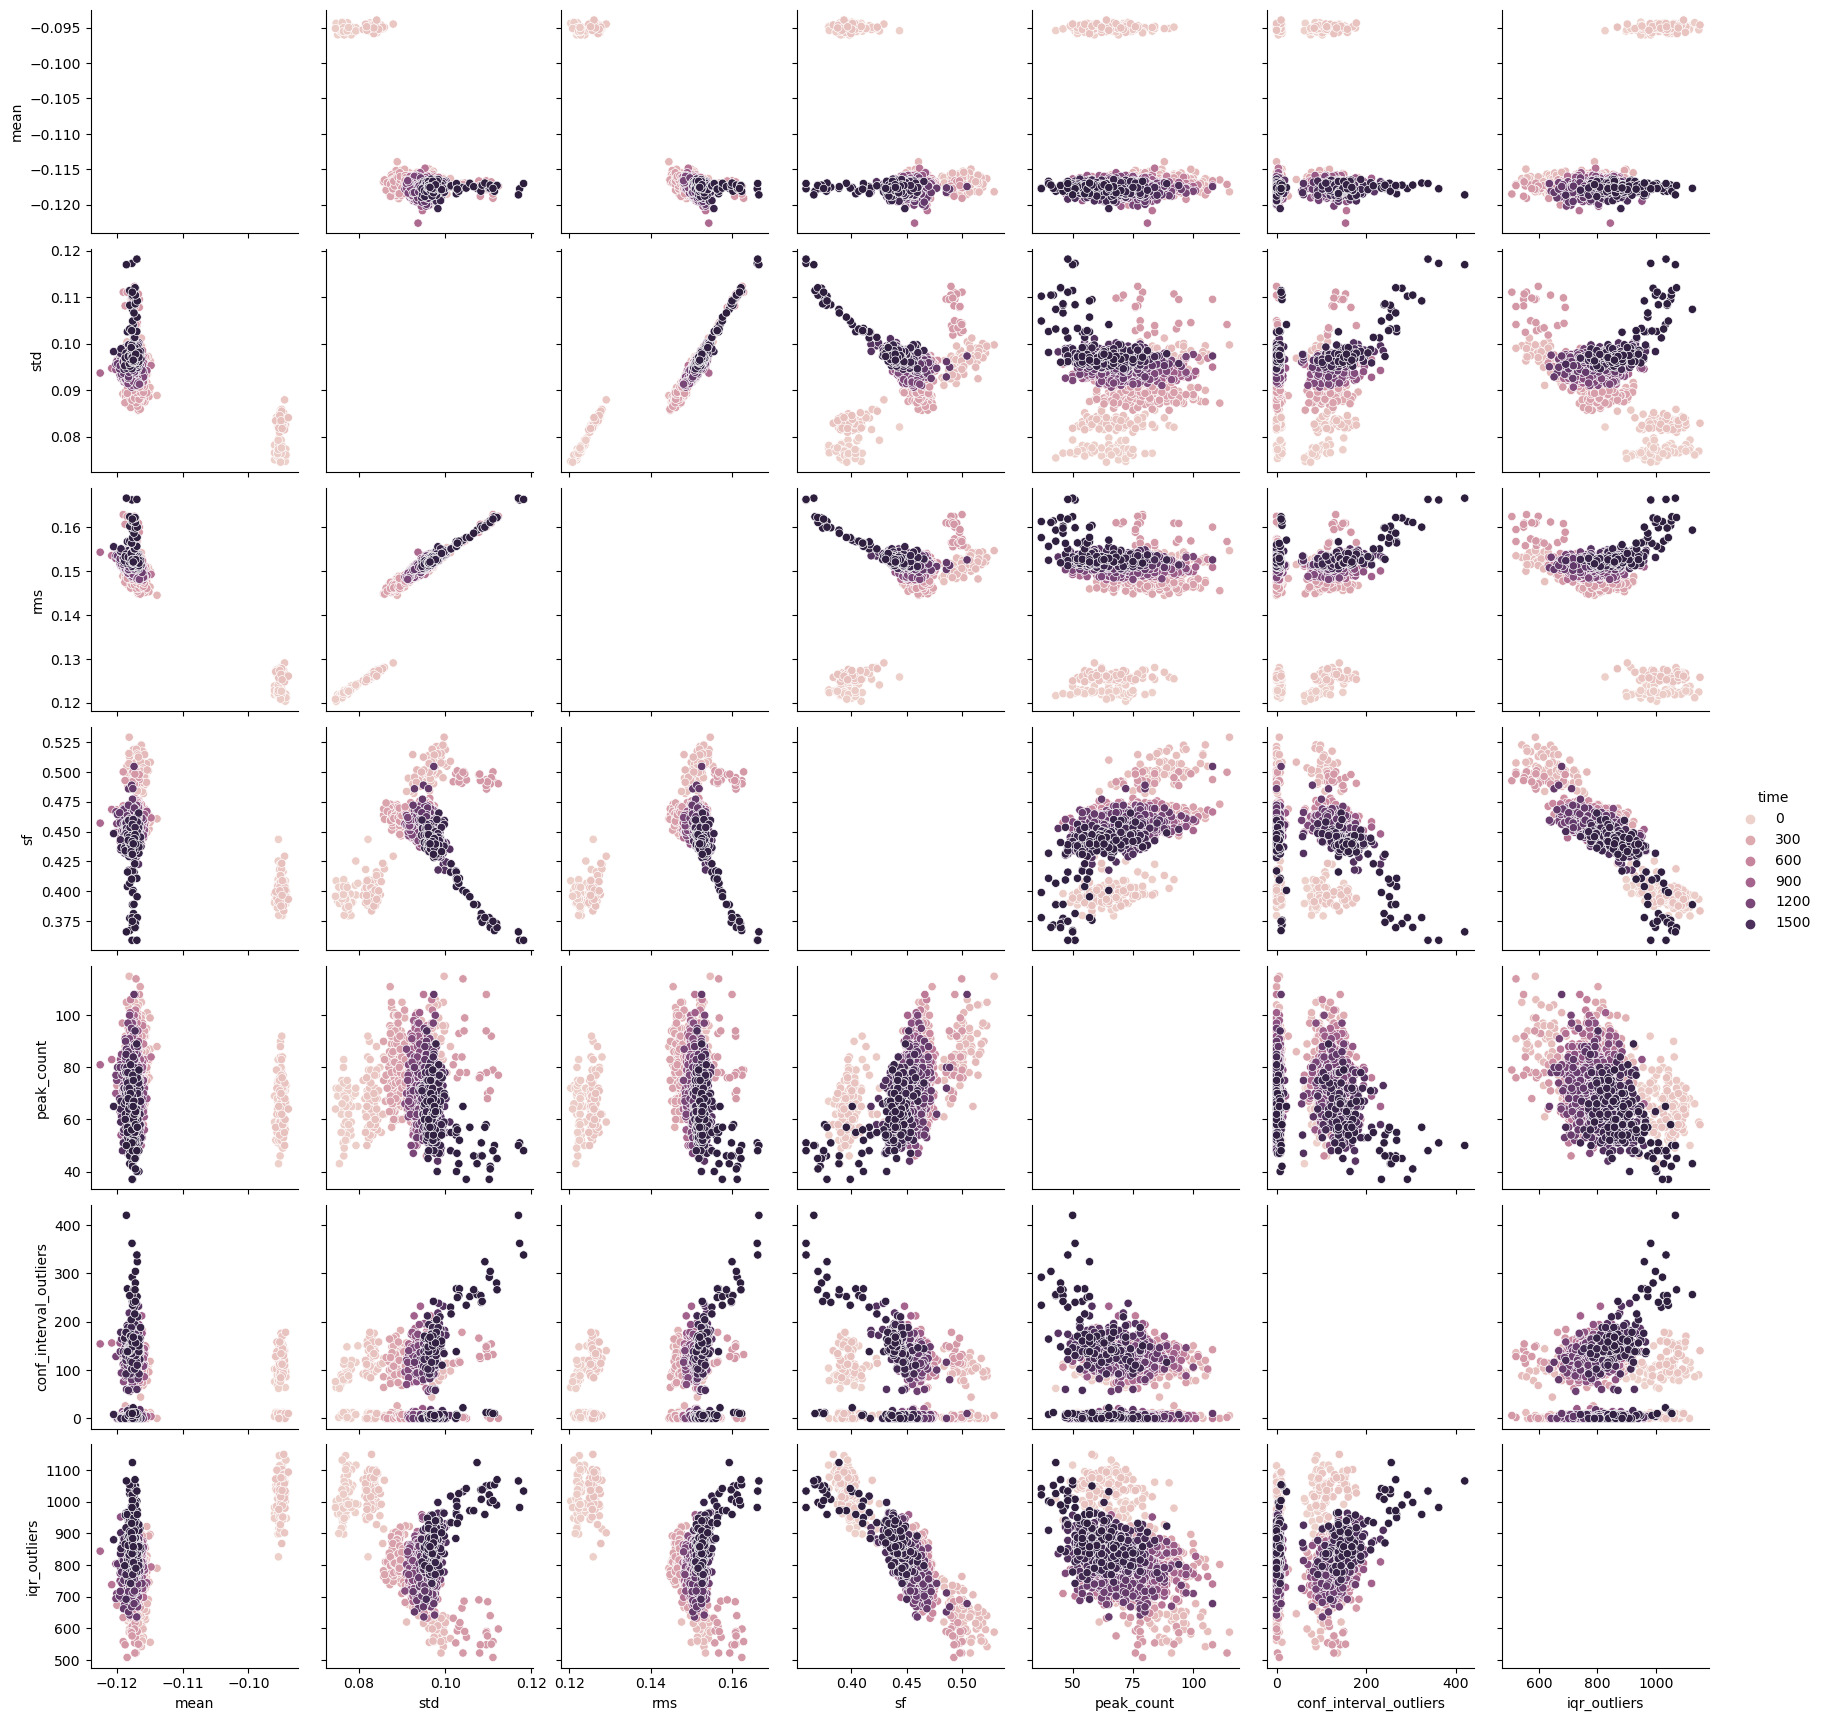

In [134]:
ax=plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
pca_data=PCA(n_components=1).fit_transform(data_ex3.iloc[:,1:])
axes[1].scatter(data_ex3['time'],pca_data,s=0.5)
axes[1].set_xlabel('Time In Hours')
axes[1].set_ylabel('PCA transformed variables')
axes[1].set_title('Change in PCA transformed x with increase in time')
pca_data=PCA(n_components=2).fit_transform(data_ex3)
axes[0].scatter(pca_data[:,0],pca_data[:,1],s=0.5)
axes[0].set_xlabel('PCA transformed variable 1')
axes[0].set_ylabel('PCA transformed variable 2')
axes[0].set_title('Spread Of 2 PCA Variables')
plt.tight_layout()
plt.show()

pairplot(data_ex3,hue='time')

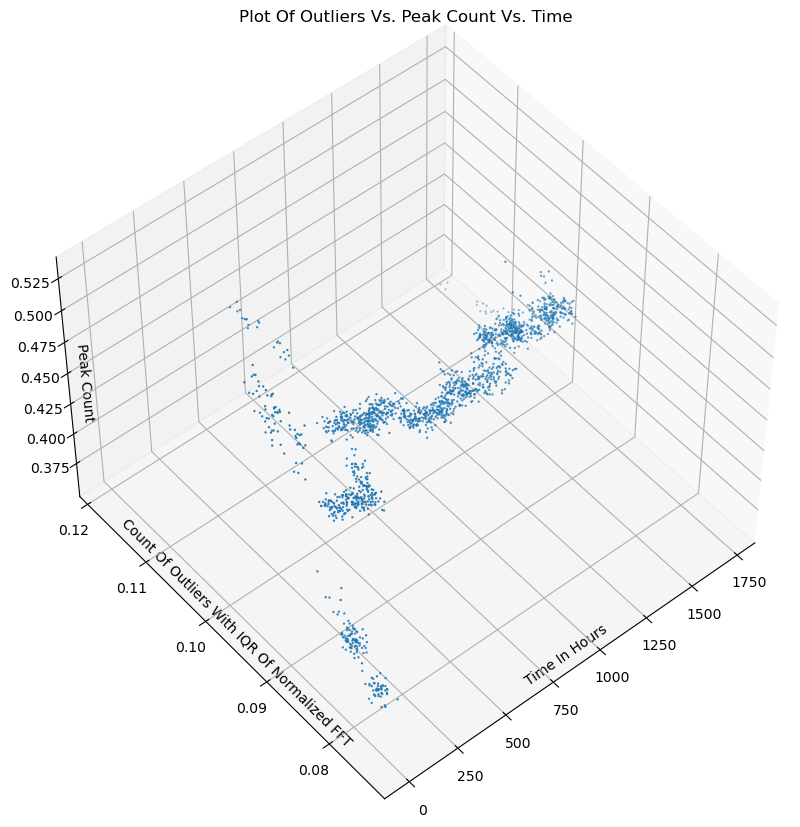

In [4]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.scatter(data_ex3['time'],data_ex3['std'],data_ex3['sf'],s=0.5)
ax.view_init(elev=50, azim=230)
ax.set_xlabel('Time In Hours')
ax.set_ylabel('Count Of Outliers With IQR Of Normalized FFT')
ax.set_zlabel('Peak Count')
ax.set_title('Plot Of Outliers Vs. Peak Count Vs. Time')
# ax.set_ylim((700,1200))
# ax.set_zlim((0,80))
ax.zaxis.labelpad = -28
ax.xaxis.labelpad = -28
ax.yaxis.labelpad = -28

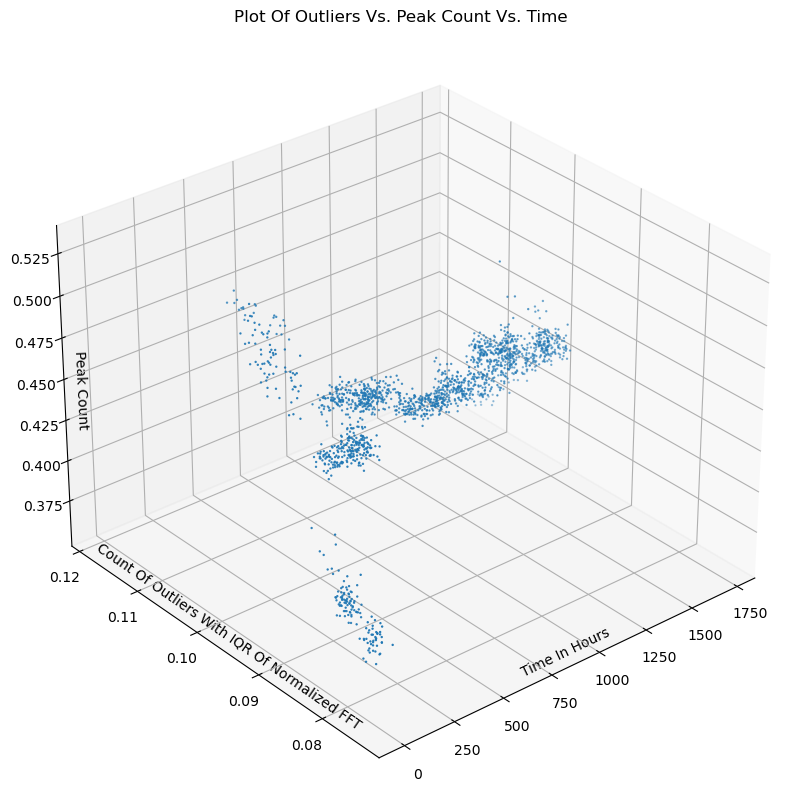

In [5]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.scatter(data_ex3['time'],data_ex3['std'],data_ex3['sf'],s=0.5)
ax.view_init(elev=30, azim=230)
ax.set_xlabel('Time In Hours')
ax.set_ylabel('Count Of Outliers With IQR Of Normalized FFT')
ax.set_zlabel('Peak Count')
ax.set_title('Plot Of Outliers Vs. Peak Count Vs. Time')
# ax.set_ylim((700,1200))
# ax.set_zlim((0,80))
ax.zaxis.labelpad = -28
ax.xaxis.labelpad = -28
ax.yaxis.labelpad = -28

Looking at scatter plot of the ${PCA}_{excluding...time}$ Vs. Time and of $PCA_1$ Vs. $PCA_2$. We see that they are the same. $PCA_1$ just happens to be time, but changed to be centered around 0. The contents of the plot itself don't show many clusters which would be easy to see visually. But they do show 4 interesting changes in shape and pattern. We don't have any reasoning for why these shapes appeared or why it is 4 specifically, but it is nice to see that at the beginning of time there is a different pattern than at the end. For clarity, we illustrated the changes in shape or pattern using manually inputted red lines.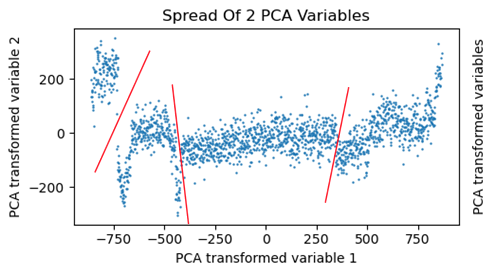

In the pairplot, we see many plots that separate the data into different blobs. Most plots appear as blobs that slide into one another. 

The most interesting is the Spectral Flatness Vs. RMS or STD showing this interesting chicken leg sort shape. Looking at the hue, we decided to plot it in 3D to see how many different shapes we would see. Indeed we see in the 3D plot that the data is very easy to separate visually, with maybe 3-4 clusters. 

A second interesting shape is how every variable plotted against 'confidence interval outliers' always has 2 blobs, with one sticking close to 0. We actually do know the reason behind this, we just didn't know it was this severe. The issue is that the count of outliers per csv file is determined through fitting a gamma distribution to the Normalized FFT. Fitting a gamma distribution doesn't always work well for each data set. Apart from that we chose an extremely high confidence interval of (1 - 1e-10). 

It makes sense that this leads to a lot of outlier counts that equal 0. The best way to solve this is to get rid of this feature for Exercise 3, which is what we'll do.

Looking at the intent behind constructing these clusters, there are two use cases we can imagine.
1. Understanding how many degradation stages there are for bearing 1 and classifying future data into one of these stages.
2. Understanding how many degradation stages there in just this specific scenario.

In the first use case, we must first learn how many stages there are and then create a clustering model which allows for classifying future data. This restriction for the clustering model would not be needed under use case 2. We will assume that we're interested in use case 1, because it accomplishes the same as use case 2, but more.

What this means is that applying DBSCAN as the final clustering method isn't possible as it violates this rule.

In [140]:
cols.remove('conf_interval_outliers')
data_ex3 = data_ex3[cols]

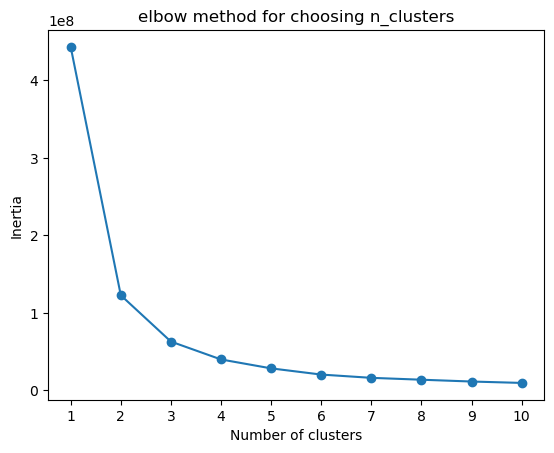

In [141]:
inertias = []

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters,n_init=10)
    kmeans.fit(data_ex3)
    
    inertias.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('elbow method for choosing n_clusters')
plt.xticks(range(1, 11))
plt.show()

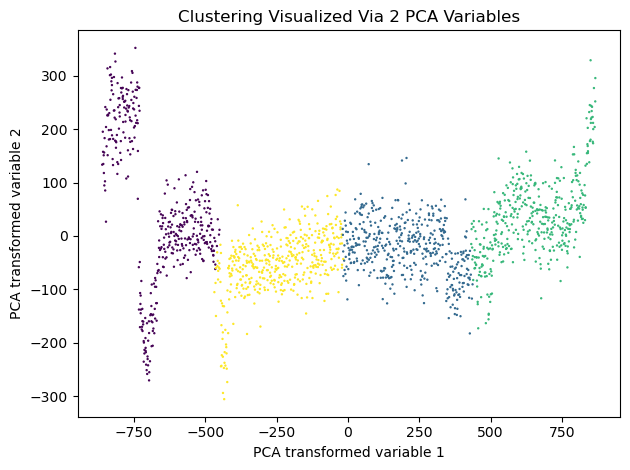

In [150]:
Cluster_labels=KMeans(n_clusters=4,n_init=10).fit(data_ex3).predict(data_ex3)
plt.scatter(pca_data[:,0],pca_data[:,1],c=Cluster_labels,s=0.5)
plt.xlabel('PCA transformed variable 1')
plt.ylabel('PCA transformed variable 2')
plt.title('Clustering Visualized Via 2 PCA Variables')
plt.tight_layout()
plt.show()

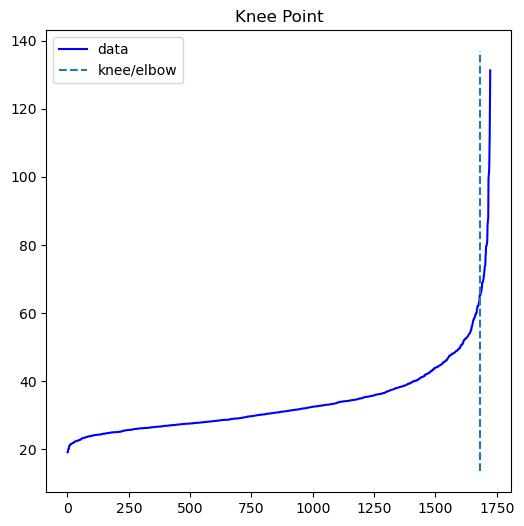

In [151]:
minimum_number_of_samples = 2*data_ex3.shape[1] # generally, 2*dimensions of the dataset (Sander et al. 1998). You should modify this based on the domain knowledge

nearest_neighbors = NearestNeighbors(n_neighbors = minimum_number_of_samples)
neighbours = nearest_neighbors.fit(data_ex3)
distances, _ = neighbours.kneighbors(data_ex3) # the distances for the first 1, 2, ..., minimum_number_of_samples neighbours for all data points

distances = np.sort(distances[:, minimum_number_of_samples - 1], axis = 0) # sort the distances

kl = KneeLocator(np.arange(len(distances)), distances, curve="convex")
kl.plot_knee()

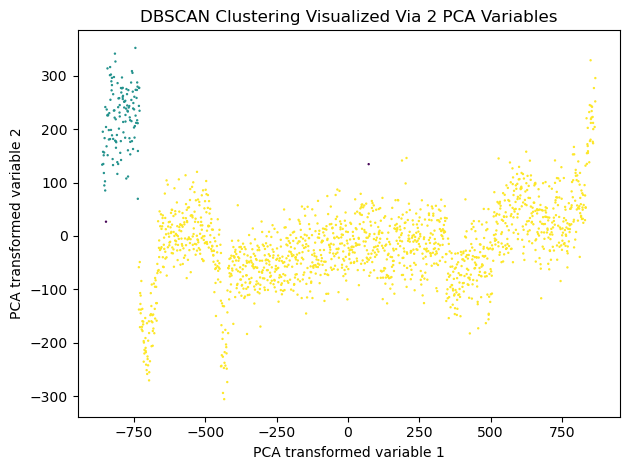

In [152]:
dbscan_clusters = DBSCAN(eps = kl.all_elbows_y[0], min_samples = 10).fit_predict(data_ex3)

plt.scatter(pca_data[:,0],pca_data[:,1],c=dbscan_clusters,s=0.5)
plt.xlabel('PCA transformed variable 1')
plt.ylabel('PCA transformed variable 2')
plt.title('DBSCAN Clustering Visualized Via 2 PCA Variables')
plt.tight_layout()
plt.show()

In [182]:
first_cluster=np.where(dbscan_clusters==0)[0]
rest_of_data=np.where(dbscan_clusters==1)[0]
mustlinks=[]
cannotlinks=[]
for i in first_cluster[1:]:
    mustlinks.append((i,first_cluster[0]))
for i in rest_of_data:
    cannotlinks.append((i,first_cluster[0]))

using COP-KMeans/ Constrained K-Means. It takes mustlinks and cannotlinks and creates constraints for a mathematical model based on the original K-Means algorithm. This essentially allows us to run K-Means with pre-defined immutable clusters.

In [191]:
clusterer = PCKMeans(n_clusters=4)
clusterer.fit(data_ex3.to_numpy(),ml=mustlinks,cl=cannotlinks) ##ml=mustlinks)
constrained_kmeans_clusters = clusterer.labels_

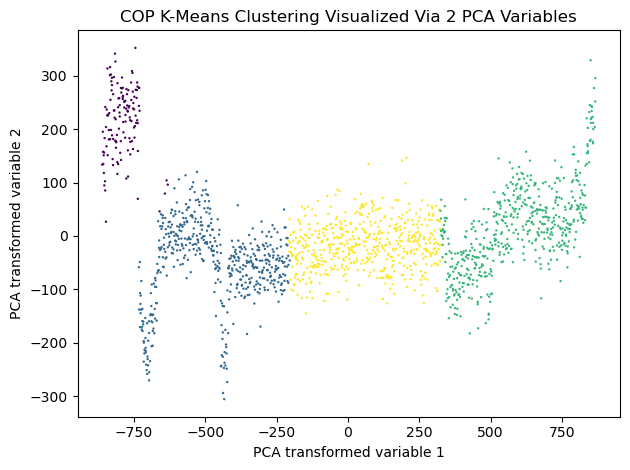

In [192]:
plt.scatter(pca_data[:,0],pca_data[:,1],c=constrained_kmeans_clusters,s=0.5)
plt.xlabel('PCA transformed variable 1')
plt.ylabel('PCA transformed variable 2')
plt.title('COP K-Means Clustering Visualized Via 2 PCA Variables')
plt.tight_layout()
plt.show()

c:\Users\danin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


time      mean       std       rms        sf  peak_count  \
Cluster                                                                    
0          69.119403 -0.095679  0.080989  0.125382  0.400041   66.104478   
1         393.829502 -0.117101  0.093606  0.149959  0.469258   77.969349   
2        1454.500000 -0.117747  0.097198  0.152701  0.445713   65.531599   
3         920.498113 -0.117507  0.093976  0.150468  0.453971   73.533962   

         iqr_outliers  
Cluster                
0         1021.261194  
1          754.461686  
2          831.940520  
3          794.158491

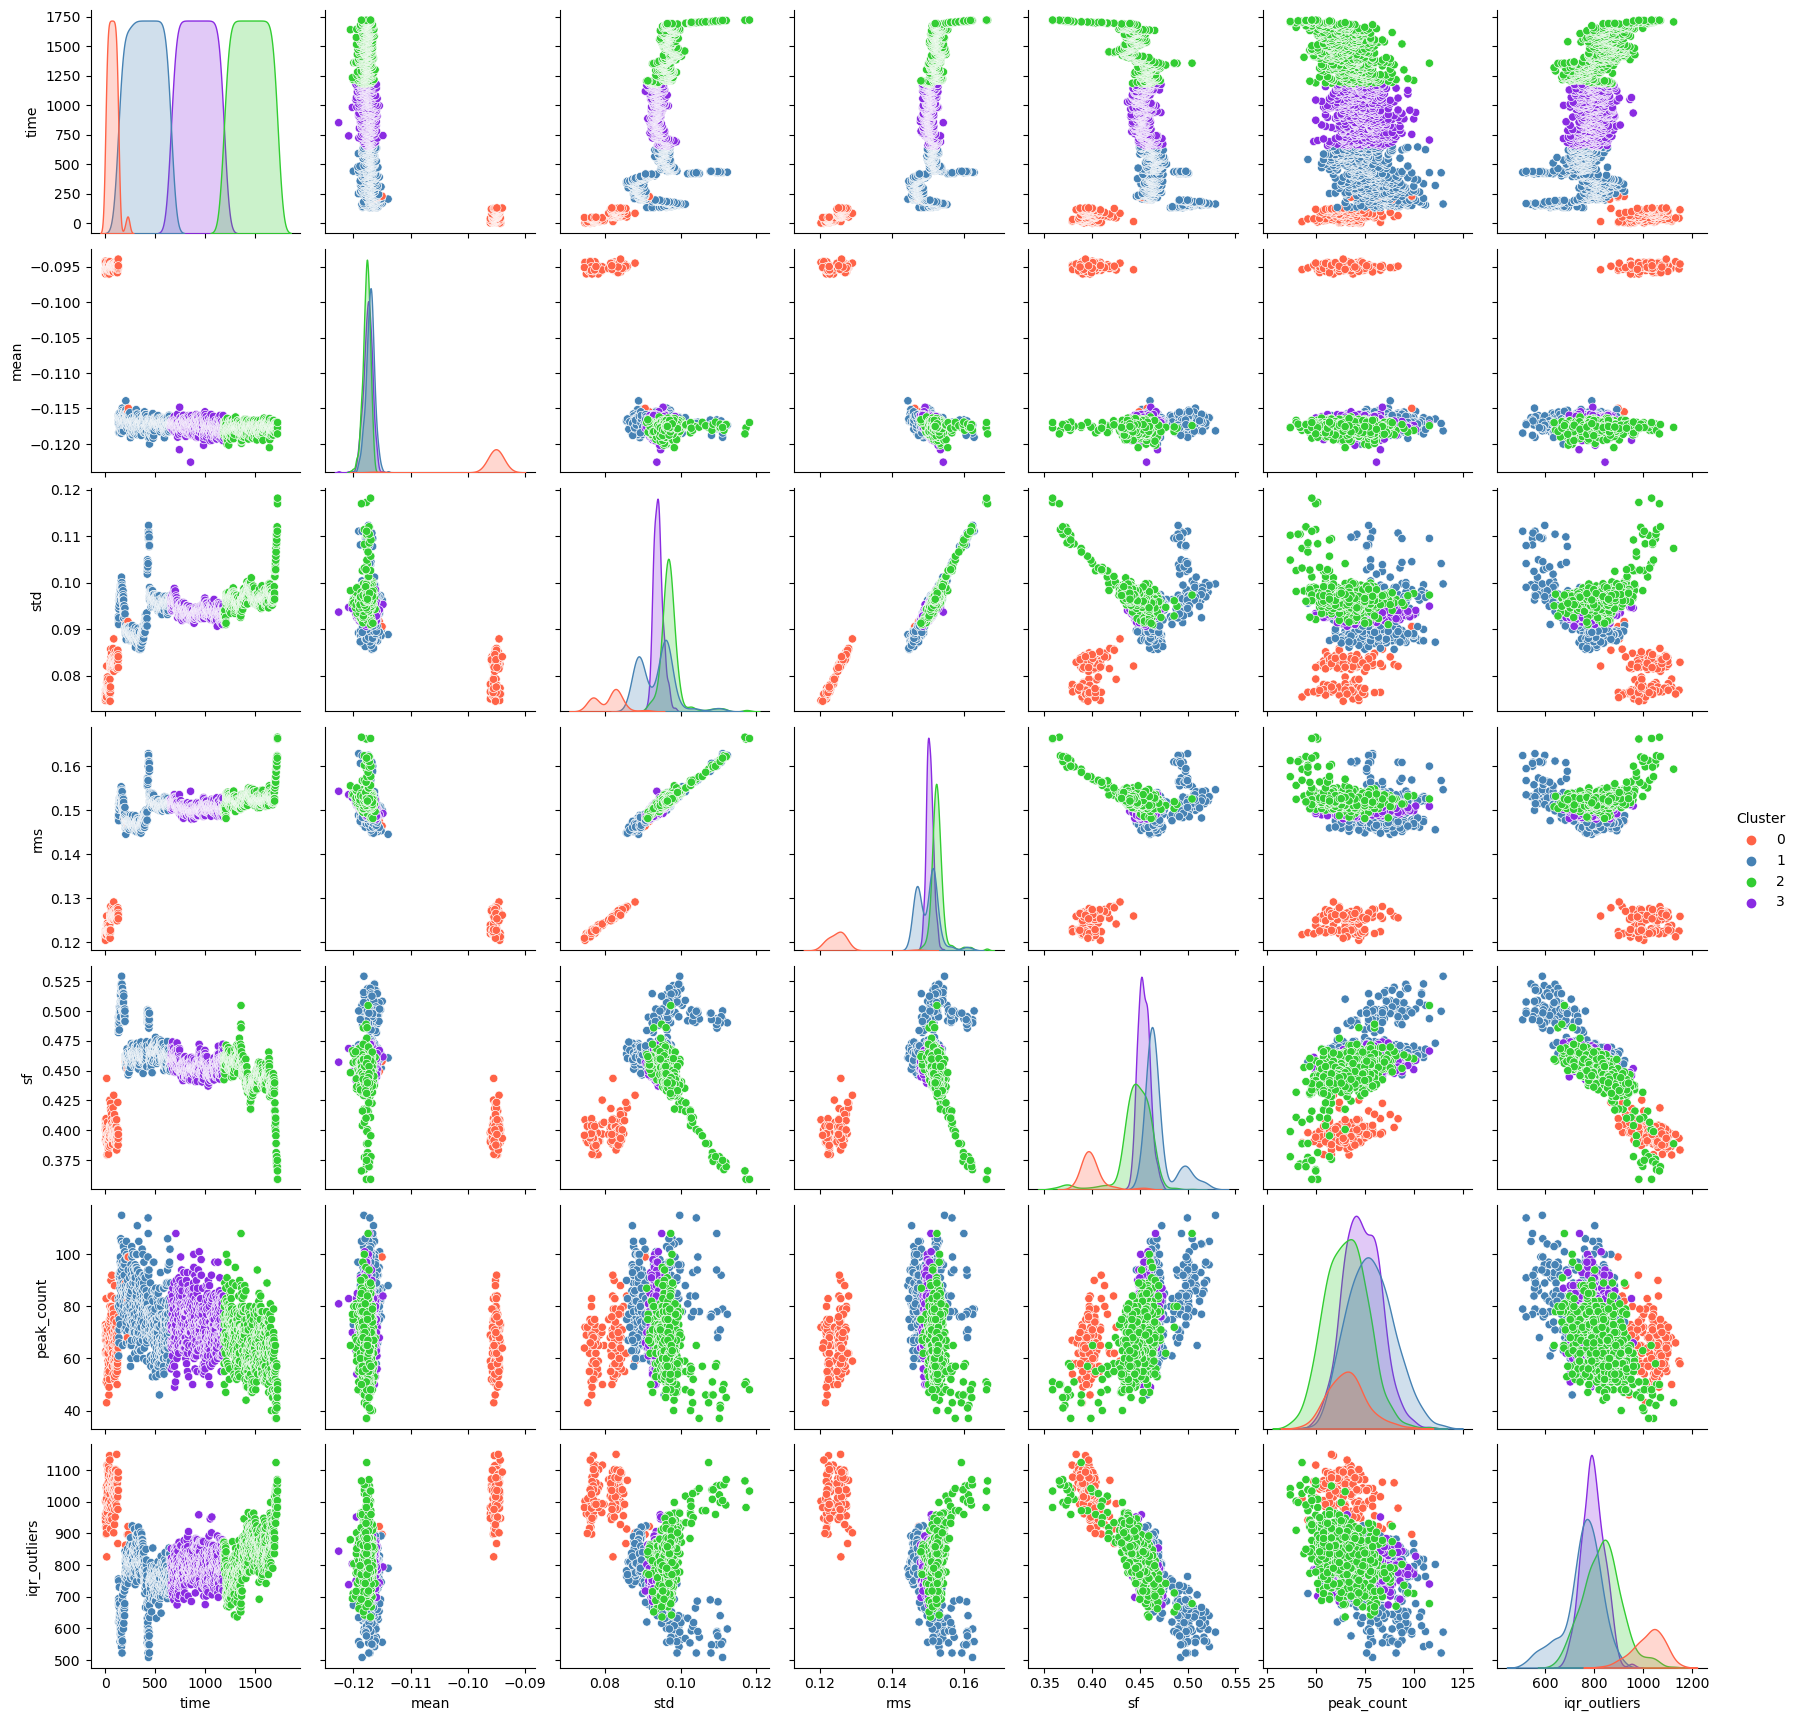

In [193]:
data_with_clustering_labels = data_ex3
data_with_clustering_labels['Cluster'] = clusterer.labels_
means_per_cluster=data_with_clustering_labels.groupby(by='Cluster').mean()
custom_palette = ["#FF6347", "#4682B4", "#32CD32", "#8A2BE2"]
pairplot(data_with_clustering_labels, hue = 'Cluster', palette = custom_palette)
means_per_cluster
#We decide the stages correspond with the following clusters:
#Cluster 0 = Stage 0
#Cluster 1 = Stage 1
#Cluster 3 = Stage 2
#Cluster 2 = Stage 3
#We decided this based on what the mean time was for each cluster and then ordered the clusters in ascending mean time. 

We decide the stages correspond with the following clusters:

Cluster 0 = Stage 0 = Red<br>
Cluster 1 = Stage 1 = Blue<br>
Cluster 3 = Stage 2 = Purple<br>
Cluster 2 = Stage 3 = Green

We decided this based on what the mean time was for each cluster and then ordered the clusters in ascending mean time. 

The amount of clusters was chosen through a combination of trial and error along with more traditional methods. We used the Elbow method and Knee locator to decide the number of clusters. 

According to those methods 2 clusters should be how the data is clustered. The reason why can be seen in the $PCA_1$ Vs. $PCA_2$ plot. There is a big distance separating the first blob from the rest of the data. In the rest of the data, this big gap between blobs simply doesn't appear. 

We still don't think that 2 clusters represents the stages Bearing 1 would go through accurately though. As said before there are some patterns in the data and 2 clusters aren't enough to capture each change in pattern. Due to this, we decided to ignore the elbow method.

We went with what was our intuition and tried 4 clusters with K-Means and it didn't take the first blob as 1 cluster, so we merged DBSCAN with K-Means through Constrained K-Means which is an adapted algorithm of K-Means. 

Constrained K-Means takes as extra input the data points that must be in the same cluster and also data points which should not be in the same cluster. Our approach involved running DBSCAN first, which resulted in two clusters. One of these clusters represented the initial blob. We then feeded this first cluster into Constrained K-Means with 4 clusters. Basically, we ran K-Means with a predefined cluster incapable of changing.

This time the clusters look better. The pairplot looks quite good, but we can see that there is some overlap in the Stage 0 cluster with the Stage 1 cluster as well (Mainly seen in the top-left plot). We feel that this could be fixed by running K-Means with 5 clusters.

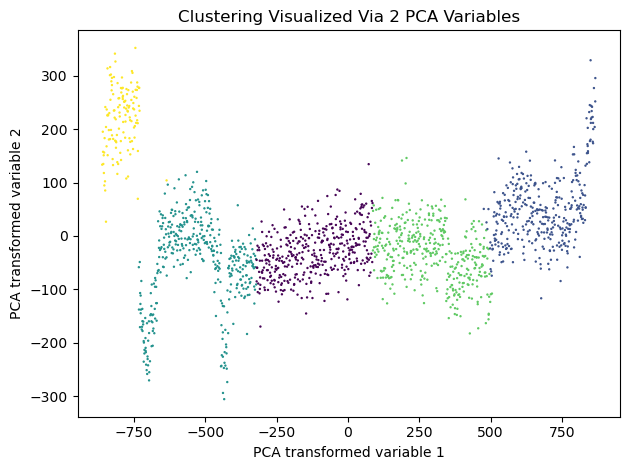

c:\Users\danin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


time      mean       std       rms        sf  peak_count  \
Cluster                                                                    
0         744.500000 -0.117336  0.094532  0.150683  0.456839   74.041667   
1        1540.821918 -0.117717  0.097949  0.153160  0.439109   62.997260   
2         335.265854 -0.117044  0.093062  0.149585  0.471009   79.536585   
3        1153.658537 -0.117740  0.094531  0.150998  0.455950   71.639024   
4          65.732824 -0.095215  0.080772  0.124886  0.398766   65.664122   

         iqr_outliers  
Cluster                
0          781.093137  
1          866.868493  
2          755.212195  
3          781.080488  
4         1024.374046

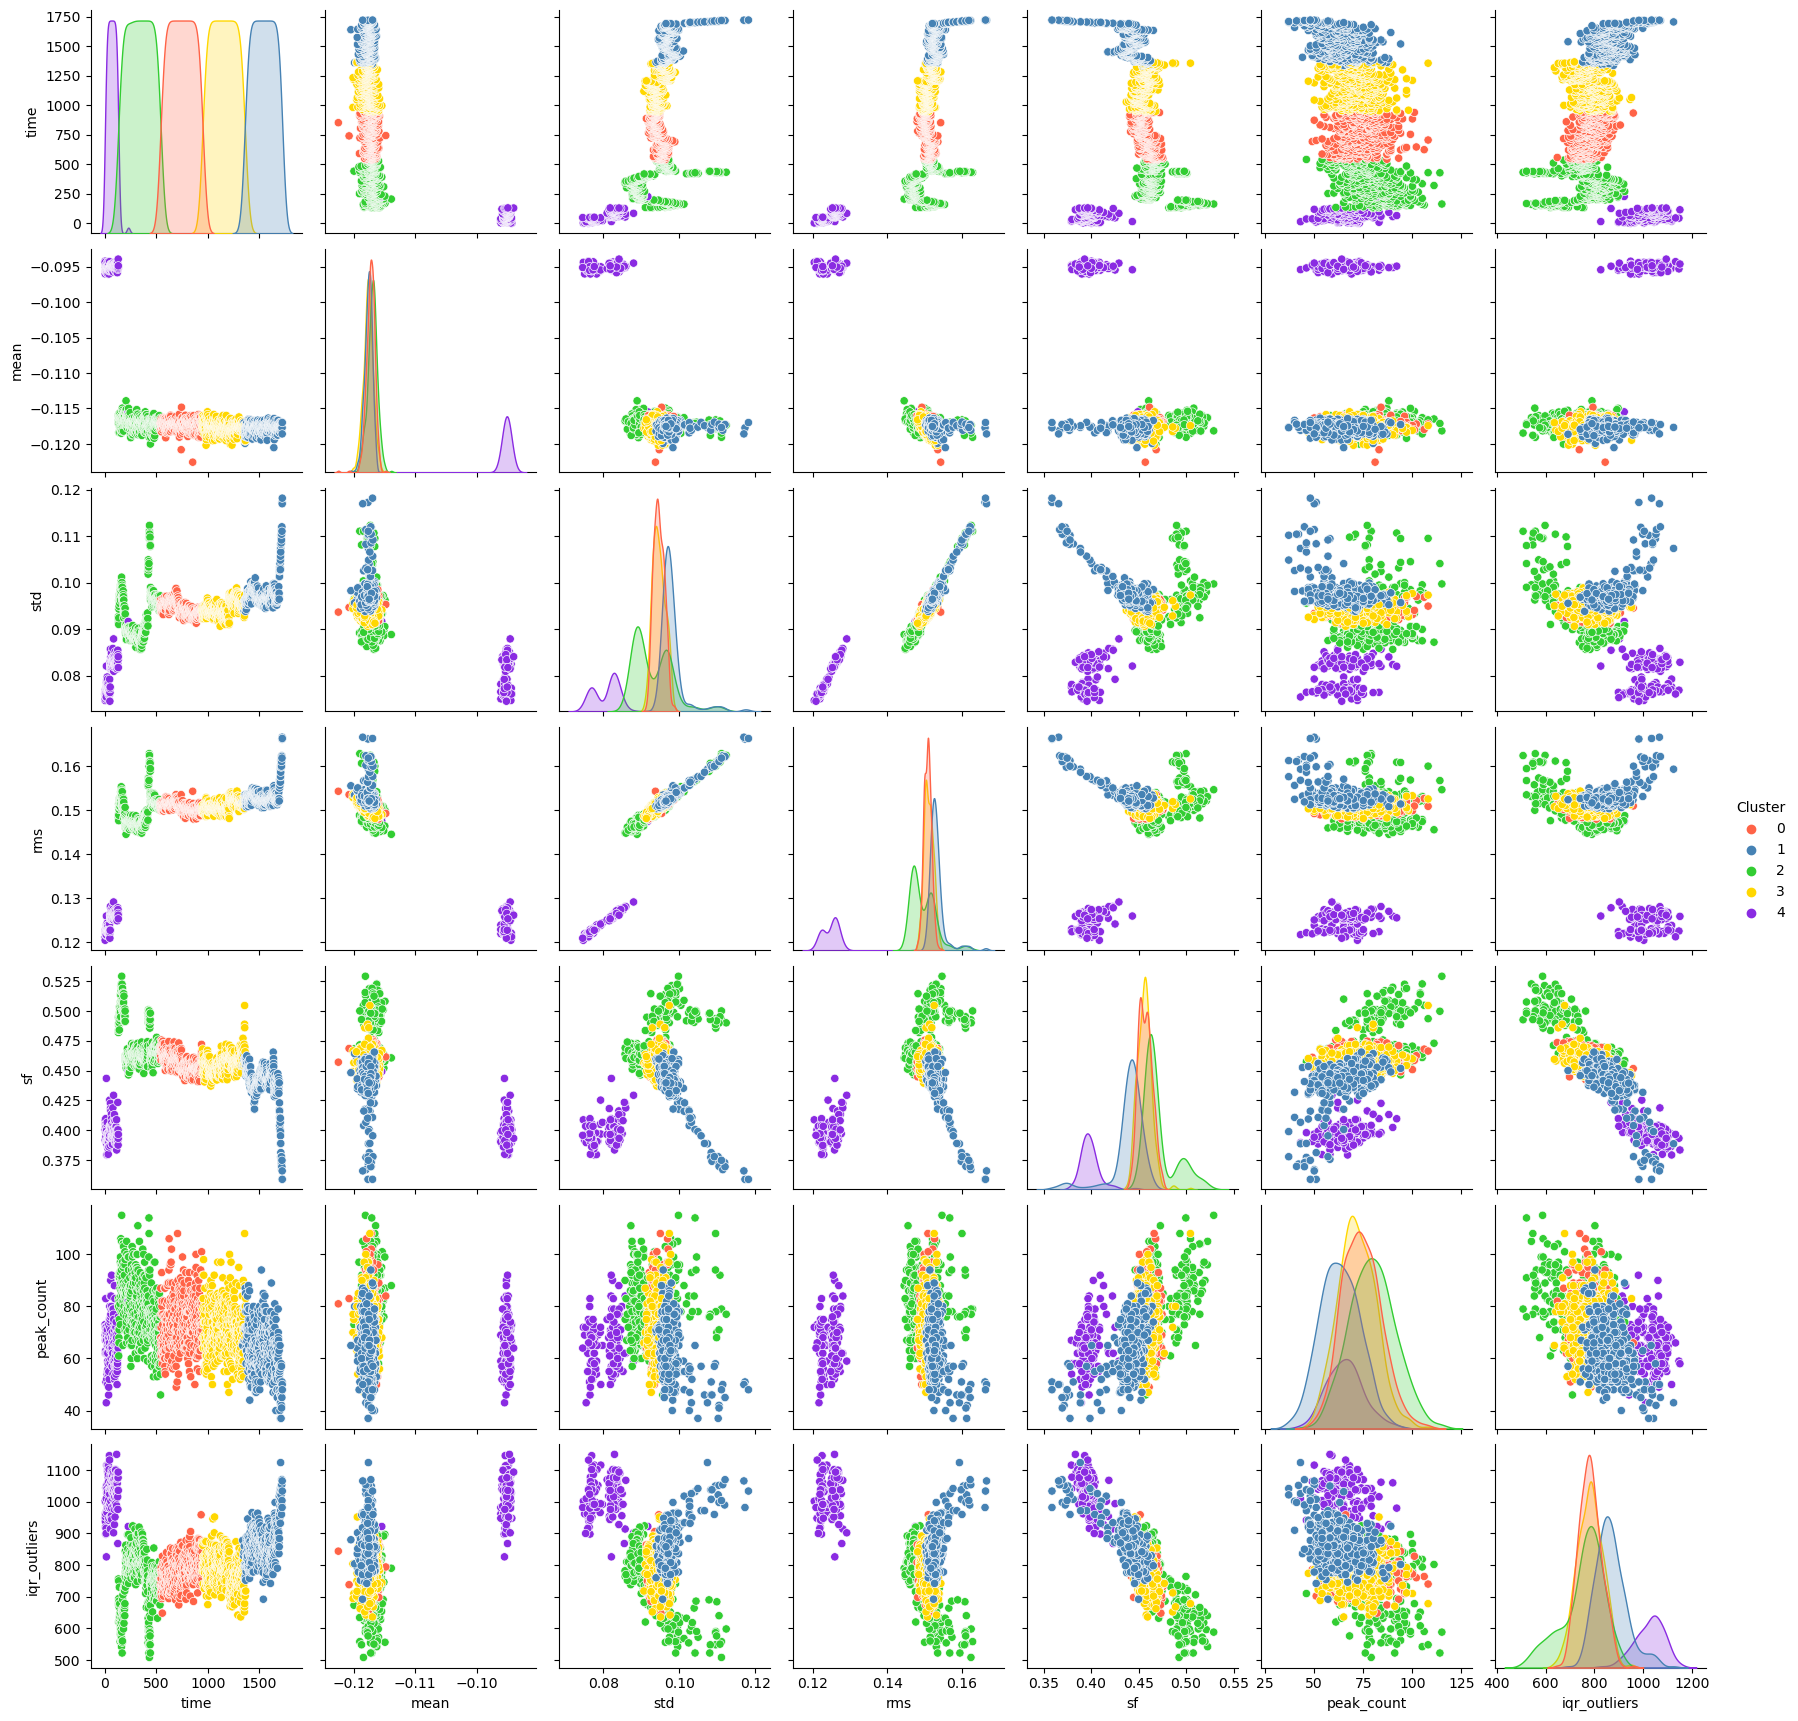

In [195]:
Cluster_labels=KMeans(n_clusters=5,n_init=10).fit(data_ex3).predict(data_ex3)
plt.scatter(pca_data[:,0],pca_data[:,1],c=Cluster_labels,s=0.5)
plt.xlabel('PCA transformed variable 1')
plt.ylabel('PCA transformed variable 2')
plt.title('Clustering Visualized Via 2 PCA Variables')
plt.tight_layout()
plt.show()
data_with_clustering_labels = data_ex3
data_with_clustering_labels['Cluster'] = Cluster_labels
means_per_cluster=data_with_clustering_labels.groupby(by='Cluster').mean()
custom_palette = ["#FF6347", "#4682B4", "#32CD32", "#FFD700", "#8A2BE2"]
pairplot(data_with_clustering_labels, hue = 'Cluster', palette = custom_palette)
means_per_cluster

This time we can just run regular K-Means with 5 clusters and avoid overcomplicating this. This time there isn't as huge of an overlap between the first stage cluster and the second stage. We think this is a marginal improvement, but it is hard to conclusively say whether it should be 4 or 5 stages.

If we choose 5 clusters, then this shows which cluster represents which stage of degradation:

Cluster 4 = Stage 0 = Purple = Early <br>
Cluster 2 = Stage 1 = Green = Unknown <br>
Cluster 0 = Stage 2 = Red = Normal <br>
Cluster 3 = Stage 2 = Yellow = Normal <br>
Cluster 1 = Stage 3 = Blue = Change

We also gave descriptions to each stage. There is the early stage which is very different from all other stages in most variables. Then there is the unknown stage, here there is a change in pattern for spectral flatness, STD and RMS. We don't know what caused this, but it seems that it signifies a change in stage before the bearing stabilizes again. This might be a possible explanation behind this strange behavior but it still isn't known.

We use cluster 0 and 3 for the same stage, this is the normal stage and the pattern remains the same for all variables throughout this stage. The reason we need 2 clusters to describe this single stage is because if we input less clusters into K-Means the early and unknown stage are turned into 1 cluster. So it is better to have too many clusters and merge some into 1 stage.

The final stage is the change stage. Here another quite big change in pattern appears for spectral flatness, STD, IQR outliers and RMS. We don't have enough information to call this a failure stage. Since Bearing 1 lasts longer than Bearing 4, it is very likely that Bearing 1 has more stages that it will go through if it runs for longer. If we had data on how Bearing 1 would change with additional hours of machine operation, we could identify more stages and rename this stage to something more appropriate.

Overall, having 4 stages seems sufficient when looking at the data.

e.1) It is hard to conclusively say whether Bearing 1 will go through the stages we defined here. But we're quite confident we identified the changes Bearing 1 underwent and appropiately ascribed a stage to them. We suspect that Bearing 1 could go through even more stages. The real doubt lies in not being able to know if this data is an isolated case or represents all first bearing for a machine of this type.'

e.2) We think Cluster analysis is really useful for tackling this issue, since we have evidence that replace Bearing 1 isn't necessary yet. Of course, if more concrete proof could be acquired, then that would be better. Ideally, the best way to tackle this would be through vibration anaylsis or maybe even differential equations that describe the real world forces acting on the bearings.

e.3) We would look at different distance metrics. A big issue is that we needed multiple clusters for what we later call 1 stage. Maybe different distance types would mitigate this problem. Another idea is to look for more clustering models which aim to isolate patterns with clusters. 